In [13]:
import argparse
import glob
import os
from copy import copy
from glob import glob
from pathlib import Path
from pprint import pprint
from time import time

import concrete.fhe
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from basicsr.archs.rrdbnet_arch import RRDBNet
from basicsr.utils import img2tensor, imwrite, tensor2img
from gfpgan.archs.stylegan2_clean_arch import ModulatedConv2d
from gfpgan_utils import *
from matplotlib import pyplot as plt
from realesrgan import RealESRGANer
from torchvision.transforms.functional import normalize
from tqdm import tqdm

from concrete.ml.torch.hybrid_model import HybridFHEModel
from gfpgan import GFPGANer

In [14]:
class Args:

    def __init__(self):

        self.input = "GFPGAN/inputs/whole_imgs"
        self.output = Path("results")
        self.version = "1.4"
        self.upscale = 5
        self.bg_upsampler = "realesrgan"
        self.bg_tile = 400
        self.suffix = None
        self.only_center_face = False
        self.aligned = False
        self.ext = "auto"
        self.weight = 0.5


args = Args()

In [15]:
img_list = sorted(glob(f"{args.input}/*"))

os.makedirs(args.output, exist_ok=True)

assert len(img_list) >= 1

img_list

['GFPGAN/inputs/whole_imgs/00.jpg',
 'GFPGAN/inputs/whole_imgs/10045.png',
 'GFPGAN/inputs/whole_imgs/BlakeLively.jpg']

In [16]:
class GFPGANFHEHybridWrapper(GFPGANer):
    def __init__(self, **kwargs):

        super().__init__(
            model_path=get_gfpgan_path(),
            upscale=kwargs.get("upscale", 2),
            arch="clean",
            channel_multiplier=2,
            bg_upsampler=RealESRGANer(
                scale=2,
                model_path="https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth",
                model=RRDBNet(
                    num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2
                ),
                tile=kwargs.get("bg_tile", 0),
                tile_pad=10,
                pre_pad=0,
                half=torch.cuda.is_available(),
            ),
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        )

        # Model 1
        self.face_helper = self.face_helper

        # Model 2
        self.base_gfpgan = self.gfpgan
        self.hybrid_gfpgan = None

        # Model 3
        self.upsampler = self.bg_upsampler.model

    def _prepare_faces(self, img, has_aligned, only_center_face):
        """Prepare faces by either resizing (aligned) or detecting landmarks (unaligned)."""
        if has_aligned:
            img = cv2.resize(img, (512, 512))
            self.face_helper.cropped_faces = [img]
        else:
            self.face_helper.read_image(img)
            # Get face landmarks
            self.face_helper.get_face_landmarks_5(
                only_center_face=only_center_face, eye_dist_threshold=5
            )
            # Align and warp each face
            self.face_helper.align_warp_face()

    def _prepare_data(self, cropped_face):
        # Prepare data
        cropped_face_t = img2tensor(cropped_face / 255.0, bgr2rgb=True, float32=True)
        normalize(cropped_face_t, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
        cropped_face_t = cropped_face_t.unsqueeze(0).to(self.device)
        return cropped_face_t

    def _finalyze(self, img, has_aligned, paste_back):

        if not has_aligned and paste_back:
            bg_img = None
            if self.bg_upsampler is not None:
                bg_img = self.bg_upsampler.enhance(img, outscale=self.upscale)[0]

            self.face_helper.get_inverse_affine(None)
            restored_img = self.face_helper.paste_faces_to_input_image(upsample_img=bg_img)
            return self.face_helper.cropped_faces, self.face_helper.restored_faces, restored_img
        else:
            return self.face_helper.cropped_faces, self.face_helper.restored_faces, None

    def forward(self, img, fhe_mode="disable", **kwargs):
        """Forward pass with FHE mode, handling face preparation and restoration."""

        assert fhe_mode is None or (
            fhe_mode in ["disable", "execute", "simulate"] and self.hybrid_gfpgan is not None
        ), "Hybrid model is not initialized. Please run `use_hybrid_model` before."

        has_aligned = kwargs.get("has_aligned", False)
        only_center_face = kwargs.get("only_center_face", False)
        paste_back = kwargs.get("paste_back", True)
        weight = kwargs.get("weight", 0.5)
        return_rgb = kwargs.get("return_rgb", False)

        self.face_helper.clean_all()

        # Prepare aligned or unaligned faces
        self._prepare_faces(img, has_aligned, only_center_face)

        # Face restoration
        for cropped_face in self.face_helper.cropped_faces:

            cropped_face_t = self._prepare_data(cropped_face)

            if fhe_mode is None:
                output = self.base_gfpgan(
                    cropped_face_t, **{"return_rgb": return_rgb, "weight": weight}
                )[0]
            else:
                output = self.hybrid_gfpgan(
                    cropped_face_t,
                    fhe_mode=fhe_mode,
                    **{"return_rgb": return_rgb, "weight": weight},
                )[0]

            # Convert to image
            restored_face = tensor2img(output.squeeze(0), rgb2bgr=True, min_max=(-1, 1)).astype(
                "uint8"
            )

            self.face_helper.add_restored_face(restored_face)

        # Upsample and paste back faces to the original image
        return self._finalyze(img, has_aligned, paste_back)

    def __call__(self, img, fhe_mode="disable", **kwargs):
        return self.forward(img, fhe_mode, **kwargs)

    def compile(
        self,
        inputs,
        n_bits=5,
        rounding_threshold_bits=None,
        p_error=None,
        device: str = "cpu",
        configuration=None,
    ):
        """Compile the hybrid models."""

        if not self.hybrid_gfpgan:
            raise ValueError(
                "Hybrid model is not initialized. Please run `use_hybrid_model` before compiling."
            )

        self.n_bits = n_bits

        # Compile hybrid model
        self.hybrid_gfpgan.compile_model(
            inputs,
            n_bits=n_bits,
            rounding_threshold_bits=rounding_threshold_bits,
            p_error=p_error,
            device=device,
            configuration=configuration,
        )

    def use_hybrid_model(self, remote_layers):
        """Initialize the hybrid model with specified remote layers."""
        if remote_layers == []:
            print("No remote layers specified; using the base model.")
        self.hybrid_gfpgan = HybridFHEModel(self.base_gfpgan, remote_layers)

In [17]:
linear_layer_names = extract_specific_module(
    GFPGANFHEHybridWrapper, attr="base_gfpgan", dtype_layer=torch.nn.Linear
)

input_is_latent = GFPGANFHEHybridWrapper().base_gfpgan.input_is_latent
# Remove "style_mlp"  because they are not activated
linear_layer_names = [
    name for name in linear_layer_names if input_is_latent and "style_mlp" not in name
]

conv_layer_names = extract_specific_module(
    GFPGANFHEHybridWrapper, attr="base_gfpgan", dtype_layer=torch.nn.Conv2d
)

print(f"{len(linear_layer_names)=} - {len(conv_layer_names)=}")

len(linear_layer_names)=24 - len(conv_layer_names)=79


In [18]:
img_list

['GFPGAN/inputs/whole_imgs/00.jpg',
 'GFPGAN/inputs/whole_imgs/10045.png',
 'GFPGAN/inputs/whole_imgs/BlakeLively.jpg']

In [20]:
# remote_linear_layer_names = linear_layer_names
# remote_conv_layer_names = []

# benchmark(
#     GFPGANFHEHybridWrapper,
#     remote_linear_layer_names,
#     remote_conv_layer_names,
#     [1, 3],
#     img_list[2:3],
#     output_dir=args.output,
#     suffix=args.suffix,
#     extra="only_linear_layers",
# )

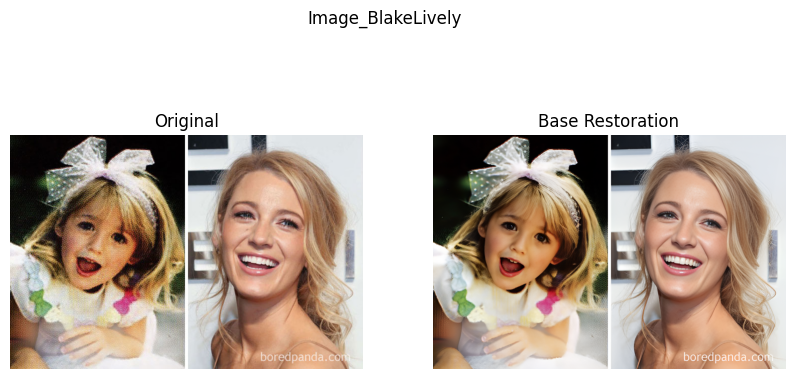

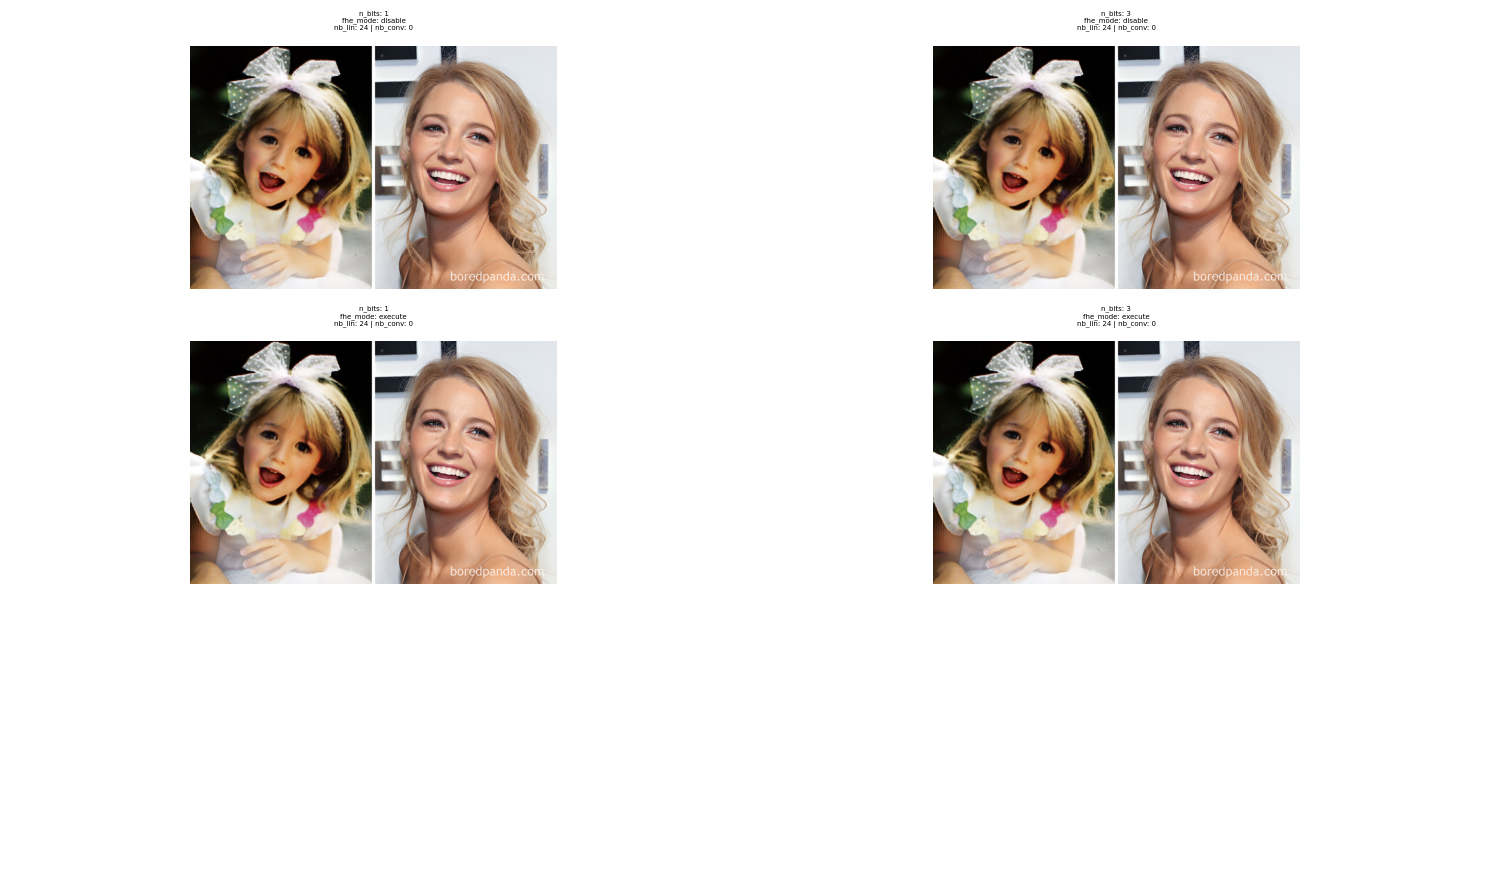

In [32]:
img_paths = glob("comparison/BlakeLively_*.*p*")

display(img_paths, verbose=True, fhe_modes=["disable", "execute"])

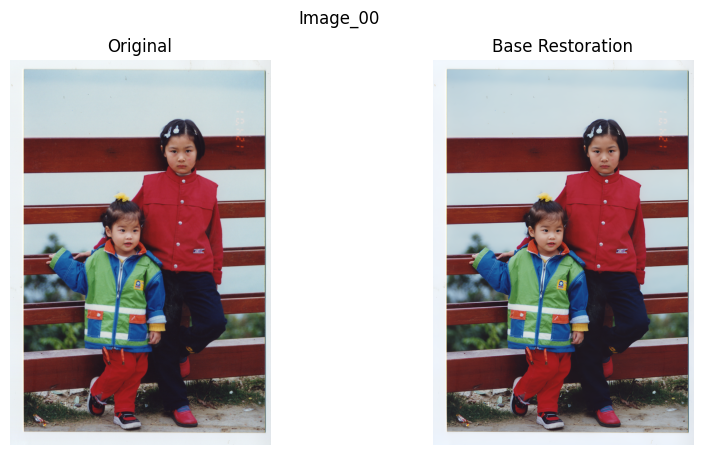

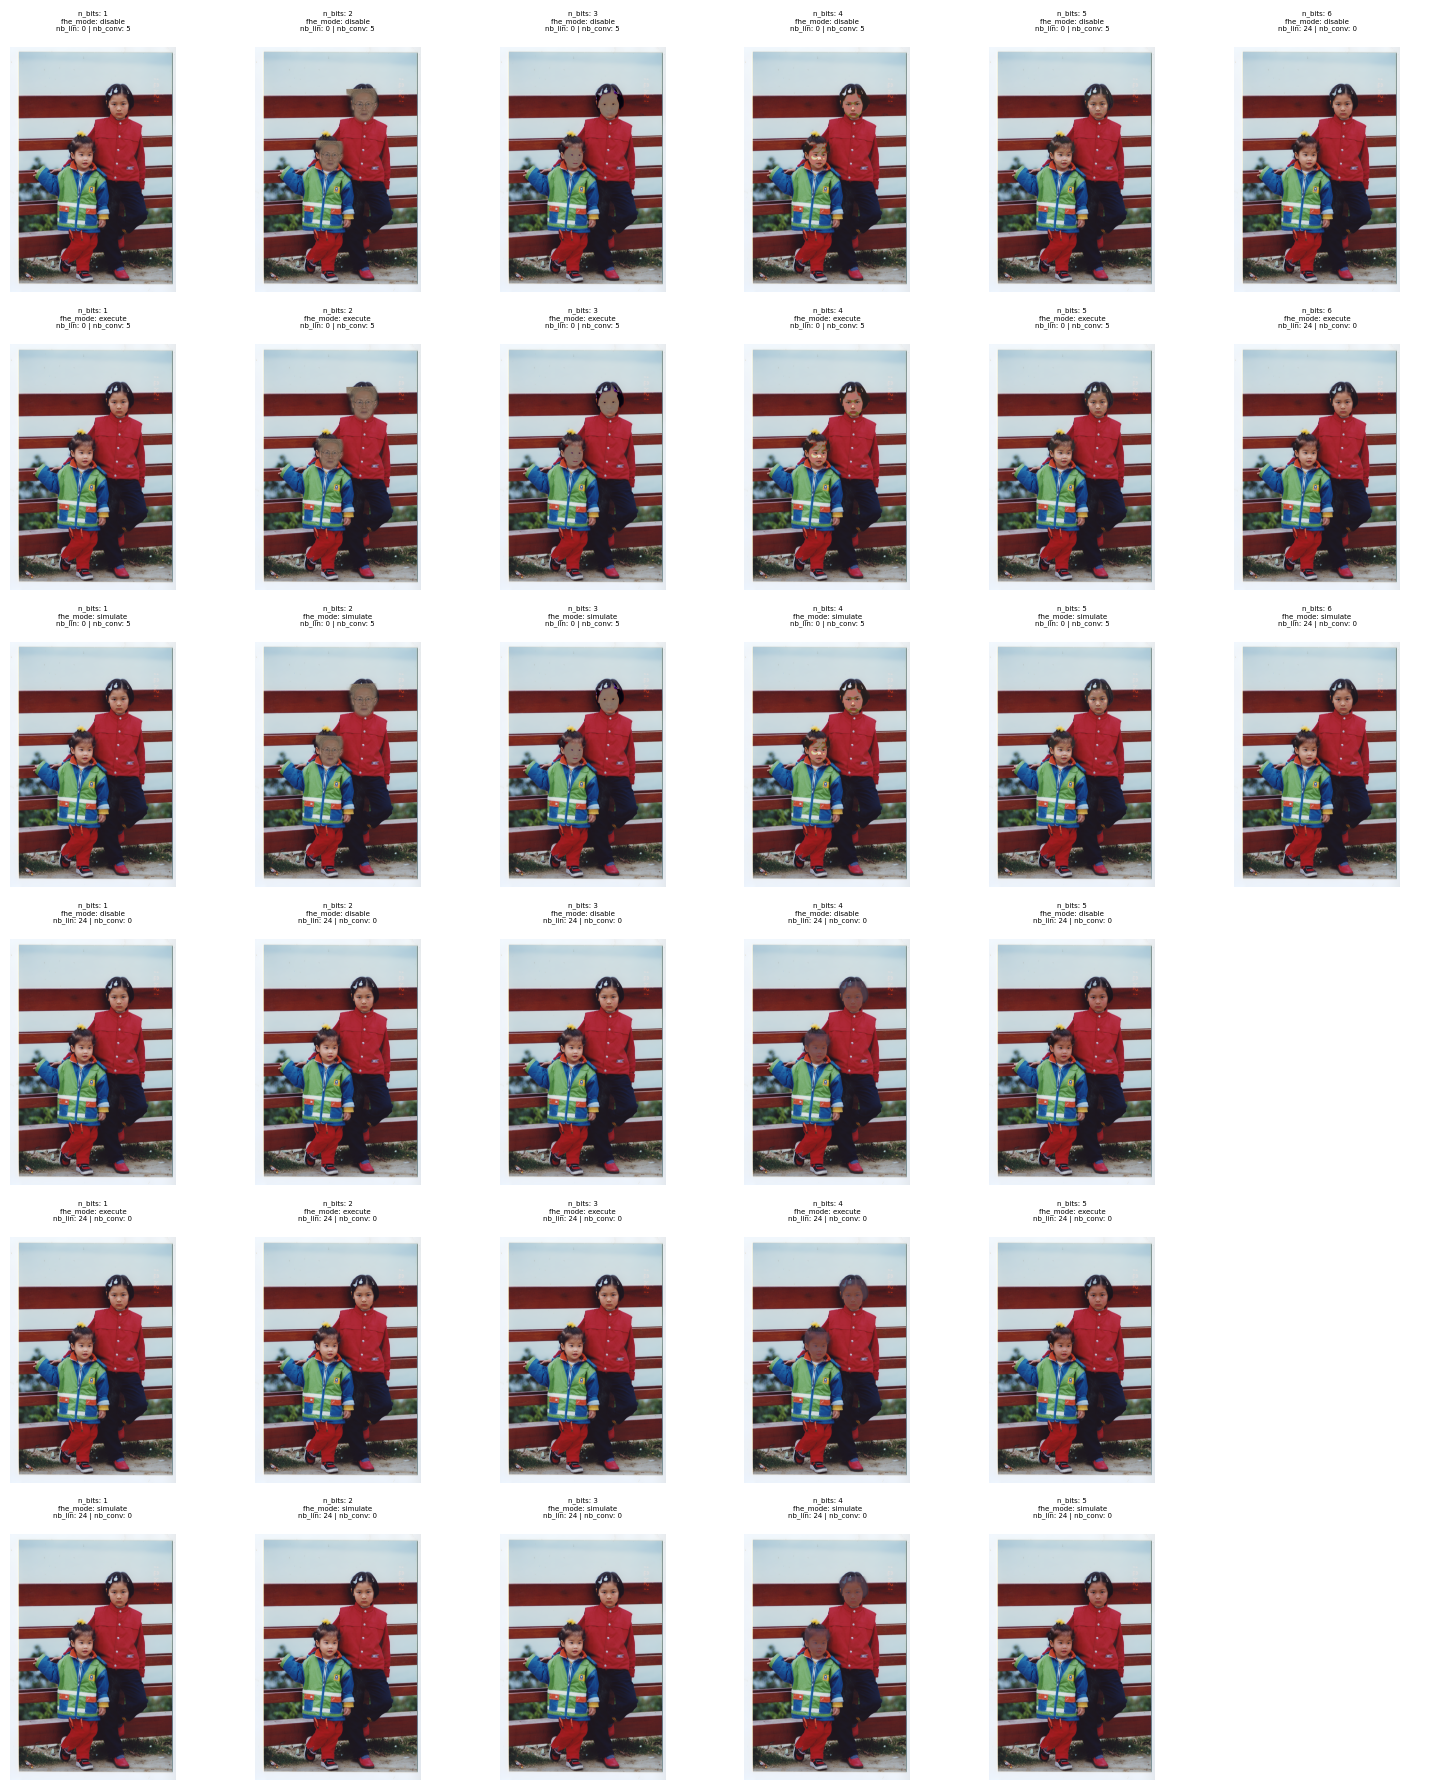

In [36]:
img_paths = glob("comparison/00_*.*p*")

display(img_paths, verbose=True, fhe_modes=["disable", "execute", "simulate"])

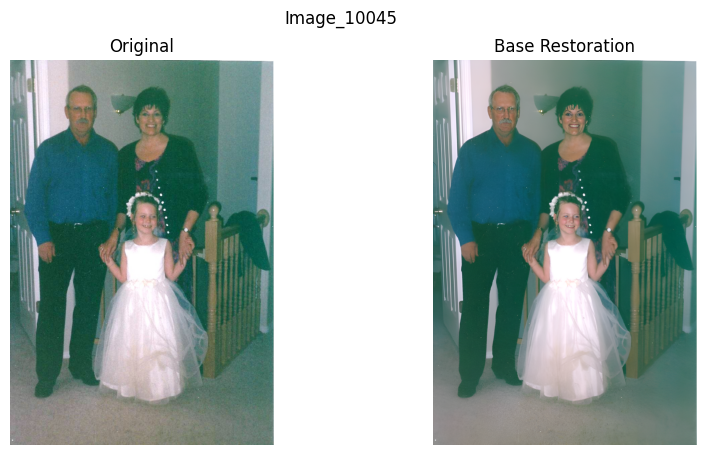

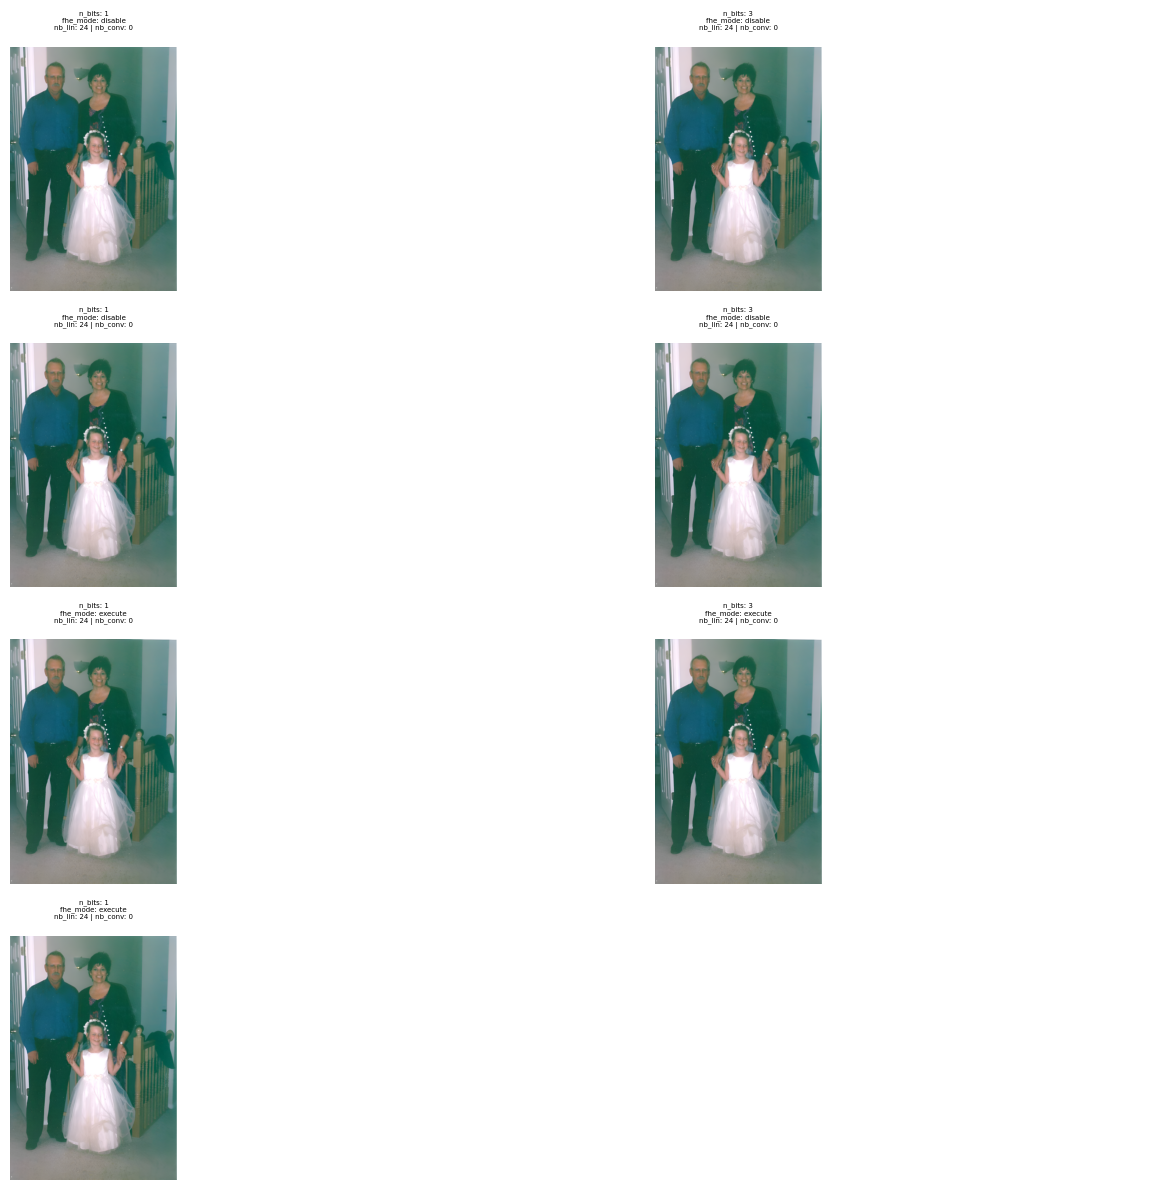

In [34]:
img_paths = glob("comparison/10045_*.*p*")

display(img_paths, verbose=True, fhe_modes=["disable", "execute"])

In [24]:
# %%time

# wrapped_gfpgan.use_hybrid_model(remote_conv_layer_names[:5])

# input_size = (3, 512, 512)
# inputs = torch.randn((1, *input_size))

# wrapped_gfpgan.compile(inputs, n_bits=2, rounding_threshold_bits=4, p_error=0.1)

In [25]:
# extra = "5_con"
# restored_images = []

# for fhe_mode in ['disable', 'simulate', 'execute']:
#     for img_path in tqdm(img_list):

#         input_img, basename, ext = read_img(img_path)
#         start_time = time()
#         cropped_faces, restored_faces, restored_img = wrapped_gfpgan(input_img, fhe_mode=fhe_mode)
#         restored_images.append(restored_img)
#         print(f"{fhe_mode=} | {wrapped_gfpgan.n_bits=}: Image restored in {time() - start_time:.2f}s")

#         save_image(restored_img, Path("comparison") / f"nb_lin=0_nb_conv=5_{fhe_mode=}_n_bits={wrapped_gfpgan.n_bits}.png")

In [26]:
# image1 = restored_images[0]
# image2 = restored_images[1]
# image3 = restored_images[2]

# image_pairs = [(image1, image2), (image1, image3), (image2, image3)]
# titles = ["Disable vs. Simulate", "Disable vs. Execute", "Simulate vs. Execute"]

# display_difference_grid(image_pairs, titles)